# Data Analysis
This notebook is used to analyze the data collected from live runs. It includes various visualizations and statistical analyses to understand the performance of the runner

## TOC:

In [1]:
from utilis.helper import extract_global_json, extract_json
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

## Try running time series cross-validation with external regressors

### Deep Learning Model

In [14]:
import os
import pandas as pd
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_lightning import Trainer
import torch

# ========================
# 1. Load & Merge All Series
# ========================
folder_path = "runs"
dataframes = []

for folder in os.listdir(folder_path):
    run_folder_path = os.path.join(folder_path, folder)
    for file in os.listdir(run_folder_path):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(run_folder_path, file), parse_dates=["time_datetime"])
            df["series_id"] = folder  # Identify which series
            dataframes.append(df)

data = pd.concat(dataframes)

# Ensure sorted order
data = data.sort_values(["series_id", "time_datetime"])
# data = data.sort_values(["series_id", "date"])

# ========================
# 2. Create Time Index
# ========================
# TFT requires an integer time index — we assign it per series
data["time_idx"] = data.groupby("series_id").cumcount()
# data["time_idx"] = range(len(data))

# Optional: Add date-based features
data["month"] = data["time_datetime"].dt.month
data["dayofweek"] = data["time_datetime"].dt.dayofweek
# data["month"] = data["date"].dt.month
# data["dayofweek"] = data["date"].dt.dayofweek

# ========================
# 3. Parameters
# ========================
max_encoder_length = 24  # how many past steps to use
max_prediction_length = 6  # forecast horizon

# ========================
# 4. Create TimeSeriesDataSet
# ========================
training_cutoff = data["time_idx"].max() - max_prediction_length

value = "velocity_mps"

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target=value,
    # target="value",
    group_ids=["series_id"],  # each series is a separate group
    min_encoder_length=max_encoder_length // 2,  # allow shorter sequences
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["series_id"],  # categorical per series
    # time_varying_known_categoricals=["dayofweek", "month"],
    variable_groups={},  # no grouped variables here
    time_varying_known_reals=["time_idx"],  # continuous features known in future
    time_varying_unknown_reals=[value],  # target is unknown in future
    # time_varying_unknown_reals=["value"],  # target is unknown in future
    categorical_encoders={"series_id": NaNLabelEncoder().fit(data.series_id)},
)

# ========================
# 5. Validation Dataset
# ========================
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# Create dataloaders
batch_size = 64
train_loader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_loader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

# ========================
# 6. Build TFT Model
# ========================
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,  # model complexity
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=1,  # regression
    loss=torch.nn.MSELoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

# Print model size
print(f"Number of parameters: {tft.size()/1e3:.1f}k")

# ========================
# 7. Train Model
# ========================
trainer = Trainer(
    max_epochs=30,
    accelerator="auto",
    devices="auto"
)
trainer.fit(
    tft,
    train_loader,
    val_loader
)

# ========================
# 8. Make Predictions
# ========================
raw_predictions, x = tft.predict(val_loader, mode="raw", return_x=True)

# Example: Get forecast for first series in validation
import matplotlib.pyplot as plt

idx = 0
tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)
plt.show()


AssertionError: data index has to be unique

R² score: 0.0404


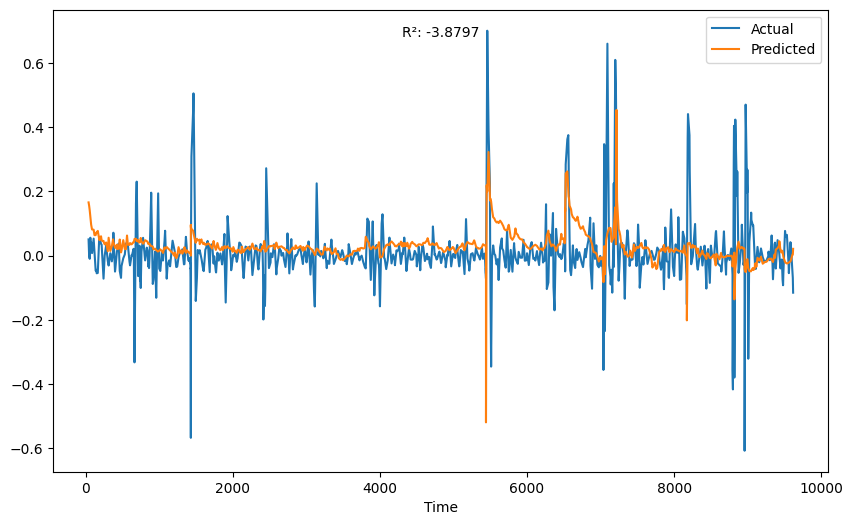

In [104]:
import os
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# =========
# Load all series
# =========
output_folder = extract_global_json('output_folder')
dataframes = []

# for folder in os.listdir(folder_path):
#     run_folder_path = os.path.join(folder_path, folder)
#     for file in os.listdir(run_folder_path):

# loop through each dataset
for folder_name in os.listdir(output_folder):
    csv_file_path = os.path.join(output_folder, folder_name, f"{folder_name}_streams.csv")
    json_file_path = os.path.join(output_folder, folder_name, f"{folder_name}_overall.json")
    # get the csv_file into a DataFrame
    df = pd.read_csv(csv_file_path, parse_dates=["time_datetime"])
    overall_data = extract_json(json_file_path)

    df["series_id"] = folder_name  # Identify which series

    # Flatten weather dict if present
    flat = overall_data.copy()
    if "weather" in flat and isinstance(flat["weather"], dict):
        for k, v in flat["weather"].items():
            flat[f"{k}"] = v
        del flat["weather"]

    # external_factors = np.tile(
    #     [flat[param] for param in constant_parameters],
    #     (len(df), 1)
    # )

    # Add constant parameters to DataFrame
    df["temp"] = flat.get("temp", None)  # Add temperature if available
    df["hum"] = flat.get("humidity", None)  # Add temperature if available

    dataframes.append(df)

data = pd.concat(dataframes).sort_values(["series_id", "time_datetime"])

# =========
# Create lag features
# =========
# def create_lags(df, lags=[1, 2, 3], value="diff_velocity_mps2"):
def create_lags(df, lags=[1, 3, 5], value="smooth_velocity_mps"):
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby("series_id")[value].shift(lag)
    return df

# initialize value name and features
# features = ["lag_1", "lag_2", "lag_3"]
features=["distance_m", 
          "smooth_heartrate_bps",
          "smooth_velocity_mps",
          "stride_length_m", 
          "smooth_altitude_m", 
          "diff_altitude_mps", 
          "smooth_headwind_mps", 
          "smooth_crosswind_mps", 
          "smooth_grade_percent",
          "series_id_enc",
        #   "temp",
        #   "hum",
        #   "month",
        #   "dayofweek"
          ]
# ]
# features = ["lag_1", "lag_2", "lag_3", "month", "dayofweek"]
# value = "smooth_velocity_mps"
value = "diff_velocity_mps2"
# value = "lag_5"
# value = "lag_0"
data = create_lags(data, lags=[0, 3, 5, 10], value="diff_velocity_mps2")

# Add date features (optional)
data["month"] = data["time_datetime"].dt.month
data["dayofweek"] = data["time_datetime"].dt.dayofweek

# Drop rows with NaNs from lagging
data = data.dropna()

# =========
# Encode series_id
# =========
encoder = OrdinalEncoder()
data["series_id_enc"] = encoder.fit_transform(data[["series_id"]])
# =========
# Define features & target
# =========
X = data[features]
y = data[value]

# =========
# Train/test split (time order preserved)
# =========
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# =========
# Polynomial regression pipeline
# =========
poly_degree = 2  # try 2 or 3
pipeline = Pipeline([
    ("poly", PolynomialFeatures(degree=poly_degree, include_bias=False)),
    ("model", LinearRegression())
])

pipeline.fit(X_train, y_train)

# =========
# Evaluate
# =========
r2 = pipeline.score(X_test, y_test)
print(f"R² score: {r2:.4f}")

# test date
# test = "2025-07-31_20-07"
# test = "2025-08-06_20-14"
# test = "2025-08-06_20-43"
test = "2025-08-08_18-48"
# plot actual vs predicted
y_pred = pipeline.predict(data[data["series_id"] == test][features])
# x = "time_datatime"
x = "distance_m"
plt.figure(figsize=(10, 6))
plt.plot(data[data["series_id"] == test][x], data[data["series_id"] == test][value], label="Actual")
plt.plot(data[data["series_id"] == test][x], y_pred, label="Predicted")
plt.text(0.5, 0.95, f"R²: {r2_score(y_pred, data[data["series_id"] == test][value]):.4f}", ha='center', va='center', transform=plt.gca().transAxes)
plt.xlabel("Time") 
plt.legend()
plt.show()


In [ ]:
def external_factor_importance(external_parameters: list, constant_parameters: list, target_columns: list):

    output_folder = extract_global_json('output_folder')
    # Prepare features including external factors
    all_features = []
    all_targets = []
    
    # loop through each dataset
    for folder_name in os.listdir(output_folder):
        csv_file_path = os.path.join(output_folder, folder_name, f"{folder_name}_streams.csv")
        json_file_path = os.path.join(output_folder, folder_name, f"{folder_name}_overall.json")
        # get the csv_file into a DataFrame
        df = pd.read_csv(csv_file_path)
        overall_data = extract_json(json_file_path)

        # remove rows with NaN values in the target column
        df = df.dropna()
        features = df[external_parameters].values
        targets = df[target_columns].values

        # Flatten weather dict if present
        flat = overall_data.copy()
        if "weather" in flat and isinstance(flat["weather"], dict):
            for k, v in flat["weather"].items():
                flat[f"{k}"] = v
            del flat["weather"]

        external_factors = np.tile(
            [flat[param] for param in constant_parameters],
            (len(df), 1)
        )
        # external_factors = np.full((len(df), 2), [overall_data['weather']['temp'], overall_data['weather']['humidity']])
        
        all_features.append(np.hstack([features, external_factors]))
        all_targets.append(targets)
    
    x = np.vstack(all_features)
    y = np.vstack(all_targets)
    # y = np.hstack(all_targets)
    
    # Feature names
    feature_names = external_parameters + constant_parameters

    # make them into a pandas DataFrame
    df_x = pd.DataFrame(x, columns=feature_names)
    df_y = pd.DataFrame(y, columns=target_columns)


    return df_x, df_y

df_x, df_y = external_factor_importance(
    # external_parameters=["distance_m", "smooth_heartrate_bps", "smooth_altitude_m", "diff_altitude_mps", "smooth_headwind_mps", "smooth_crosswind_mps", "smooth_grade_percent"],
    # external_parameters=["distance_m", "smooth_pace_efficiency", "smooth_heartrate_bps", "smooth_velocity_mps", "smooth_altitude_m", "diff_altitude_mps", "smooth_headwind_mps", "smooth_crosswind_mps", "smooth_grade_percent"],
    external_parameters=["distance_m", "smooth_heartrate_bps", "stride_length_m", "smooth_altitude_m", "diff_altitude_mps", "smooth_headwind_mps", "smooth_crosswind_mps", "smooth_grade_percent"],
    # external_parameters=["distance_m", "pace_efficiency", "smooth_heartrate_bps", "smooth_velocity_mps", "smooth_altitude_m", "diff_altitude_mps", "smooth_headwind_mps", "smooth_crosswind_mps", "smooth_grade_percent"],
    # external_parameters=["distance_m", "pace_efficiency", "smooth_heartrate_bps", "velocity_mps", "smooth_altitude_m", "diff_altitude_mps", "smooth_headwind_mps", "smooth_crosswind_mps", "smooth_grade_percent"],
    constant_parameters=["temp", "humidity", "pressure", "uvindex", "total_elevation_gain", "precip"],
    # target_column=["diff_heartrate_bpm"])
    # target_column=["diff_heartrate_shift_bpm"])
    # target_column=["acceleration_mps2"])
    # target_column=["acceleration_shift_mps2"])
    # target_columns=["diff_heartrate_bps2", "diff_velocity_mps2"])
    target_columns=["diff_heartrate_bps2", "smooth_velocity_mps", "smooth_cadence_rps"])


### Random Forest Regressor

In [ ]:
# Create multi-output regressor
rf_multi = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
rf_multi.fit(df_x, df_y)

# Extract feature importance for each target
importance_results = {}

for i, target in enumerate(df_y.columns):
    importance_df = pd.DataFrame({
        'feature': df_x.columns,
        'importance': rf_multi.estimators_[i].feature_importances_
    }).sort_values('importance', ascending=False)
    
    importance_results[target] = importance_df
    
    print(f"\nFeature importance for {target}:")
    print(importance_df)

### Multivariate Regression

In [ ]:
for i, target in enumerate(df_y.columns):
    print(f"{'='*10} OLS Regression Analysis for: {target} {'='*10} \n")
    
    # # Extract target variable
    # y_target = y[:, i]
    y = df_y[target]
    # Add constant for intercept
    df_x_const = add_constant(df_x)
    # feature_names_with_const = ['const'] + feature_names
    
    # Fit OLS model
    model = OLS(y, df_x_const).fit()

    # Print summary
    print(model.summary())

### Elastic Net Regression

In [ ]:
# Elastic Net Regression
from sklearn.linear_model import ElasticNet

for i, target in enumerate(df_y.columns):
    print(f"{'='*10} Elastic Regression Analysis for: {target} {'='*10} \n")
    
    # # Extract target variable
    # y_target = y[:, i]
    y = df_y[target]

    # Define the model
    model = ElasticNet(alpha=0.1, l1_ratio=0.0, max_iter=10000)  # Adjust alpha and l1_ratio as needed
    # Fit the model
    model.fit(df_x, y)
    # predict pace efficiency based on the model
    y_pred = model.predict(df_x)

    print(model.score(df_x, y))
# # # Plot the data and the fitted line
# plt.figure(figsize=(10, 6))
# plt.plot(data["distance_m"], y, label='Data Points')
# # plt.scatter(data["distance_m"], y, label='Data Points')
# plt.plot(data["distance_m"], y_pred, color='red', label='Fitted Line')

### Polynomial Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

def polynomial_ols_regression(df_x, df_y, degree=2, interaction_only=False, include_bias=False):
    """
    Perform polynomial OLS regression for multiple targets
    """
    results = {}
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, interaction_only=interaction_only, include_bias=include_bias)
    X_poly = poly.fit_transform(df_x)
    
    # Get feature names for polynomial features
    feature_names = poly.get_feature_names_out(df_x.columns)
    
    # Create DataFrame for polynomial features
    df_x_poly = pd.DataFrame(X_poly, columns=feature_names)
    
    print(f"Original features: {df_x.shape[1]}")
    print(f"Polynomial features (degree {degree}): {df_x_poly.shape[1]}")
    print(f"Interaction only: {interaction_only}")
    
    for target in df_y.columns:
        print(f"\n{'='*20} Polynomial OLS for: {target} {'='*20}")
        
        y = df_y[target]
        
        # Add constant for intercept
        df_x_poly_const = add_constant(df_x_poly)
        
        # Fit OLS model
        model = OLS(y, df_x_poly_const).fit()
        
        # Feature importance based on coefficients (excluding intercept)
        coefficients = model.params[1:]  # Exclude intercept
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'coefficient': coefficients,
            'abs_coefficient': np.abs(coefficients),
            'p_value': model.pvalues[1:]  # Exclude intercept p-value
        }).sort_values('abs_coefficient', ascending=False)
        
        # Filter significant features
        significant_features = feature_importance[feature_importance['p_value'] < 0.05]
        
        results[target] = {
            'model': model,
            'poly_transformer': poly,
            'feature_importance': feature_importance,
            'significant_features': significant_features,
            'r_squared': model.rsquared,
            'adj_r_squared': model.rsquared_adj,
            'n_significant': len(significant_features)
        }
        
        print(f"R-squared: {model.rsquared:.4f}")
        print(f"Adjusted R-squared: {model.rsquared_adj:.4f}")
        print(f"Number of significant features (p<0.05): {len(significant_features)}")
        
        print(f"\nTop 10 most important features by coefficient magnitude:")
        print(feature_importance.head(10)[['feature', 'coefficient', 'p_value']])
        
        if len(significant_features) > 0:
            print(f"\nTop 10 significant features (p<0.05):")
            print(significant_features.head(10)[['feature', 'coefficient', 'p_value']])
    
    return results

# Run polynomial regression with degree 2
poly_results_deg2 = polynomial_ols_regression(df_x, df_y, degree=2, interaction_only=False)